# Thall et al 2003

**Hierarchical Bayesian approaches to phase II trials in diseases with multiple subtypes**

Some important excerpts

![](2022-06-21-11-48-03.png)

![](2022-06-21-11-18-30.png)

![](2022-06-21-11-46-54.png)

![](2022-06-22-12-15-57.png)

In [1]:
import sys

sys.path.append("../imprint/research/berry/")
import berrylib.util as util

util.setup_nb()


In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import numpyro.infer

import jax
import jax.numpy as jnp

from jax.config import config

# This line is critical for enabling 64-bit floats.
config.update("jax_enable_x64", True)


/Users/tbent/.mambaforge/envs/imprint/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/imprint/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Checking the distributions are correct.

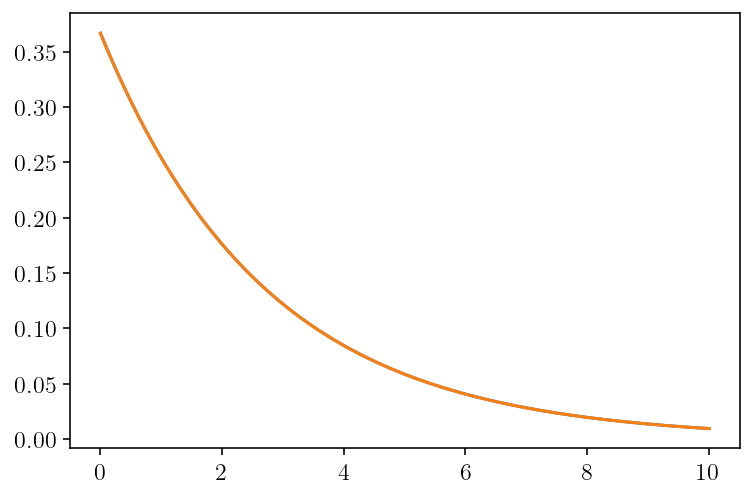

In [3]:
# Equivalence of scipy's exponential distribution and gamma distribution.
plt_vs = np.linspace(0.01, 10, 1000)
L = 1.0
rho = 1.0
mu_ttf = L * np.exp(rho)
hazard = 1.0 / mu_ttf
epdf = scipy.stats.expon.pdf(plt_vs, scale=mu_ttf)
gpdf = scipy.stats.gamma.pdf(plt_vs, 1.0, scale=mu_ttf)
plt.plot(plt_vs, epdf)
plt.plot(plt_vs, gpdf)
plt.show()


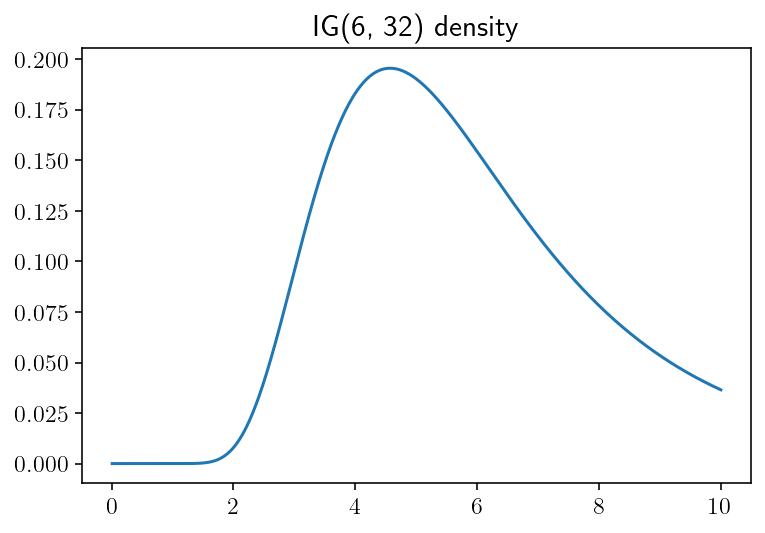

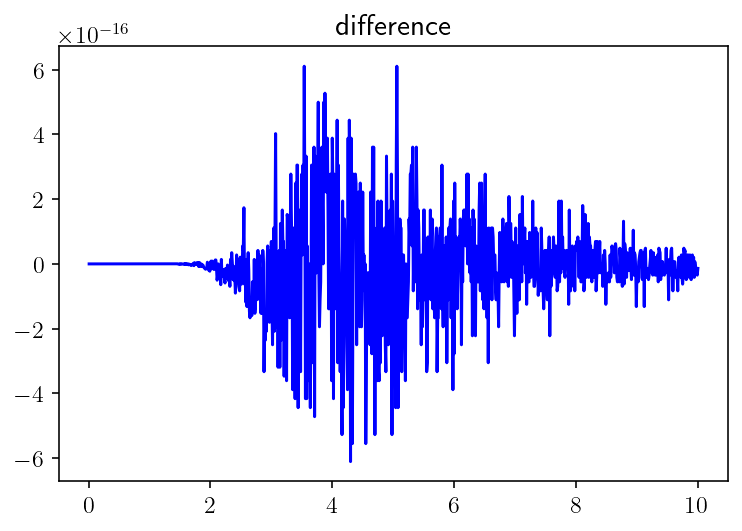

In [4]:
# Establishing the equivalence of scipy's invgamma and gamma pdfs.
alpha = 6
beta = 32
invgamma = scipy.stats.invgamma.pdf(plt_vs, alpha, scale=beta)
trans_gamma = scipy.stats.gamma.pdf(1.0 / plt_vs, alpha, scale=1.0 / beta) / (
    plt_vs**2
)
plt.title(f"IG({alpha}, {beta}) density")
plt.plot(plt_vs, invgamma)
plt.show()
plt.title("difference")
plt.plot(plt_vs, trans_gamma - invgamma, "b-")
plt.show()


## Setting up priors

mean, 95% ci
18.10, [12.06271817 27.07245591]
 5.09, [3.99527636 6.48455131]
 6.00, [4.38906768 8.18852176]


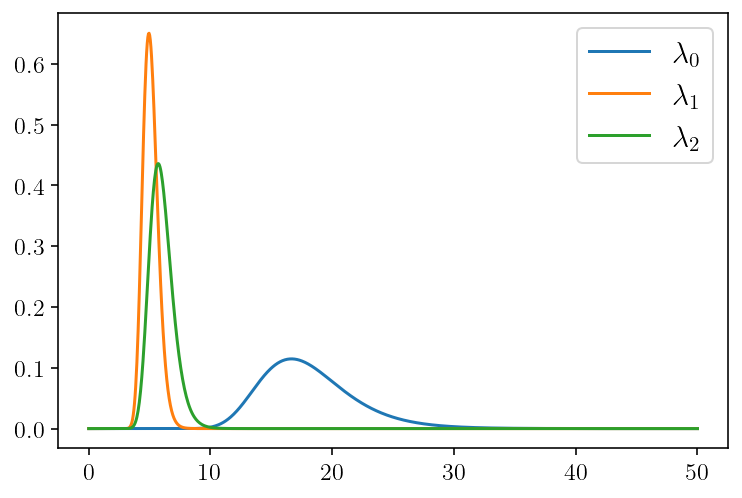

In [5]:
# Priors on lambda_j
# Check that they have the same mean and 95% CI as described in Table II of the paper.
alpha = [24, 66, 40]
beta = [416.3, 331, 234]
plt_vs = np.linspace(0, 50, 1000)
print("mean, 95% ci")
for j in range(3):
    pdf = scipy.stats.invgamma.pdf(plt_vs, alpha[j], scale=beta[j])
    plt.plot(plt_vs, pdf, label=f"$\lambda_{j}$")
    plt_vs = np.linspace(0, 50, 1000)
    mean = scipy.stats.invgamma.mean(alpha[j], scale=beta[j])
    ci = scipy.stats.invgamma.ppf([0.025, 0.975], alpha[j], scale=beta[j])
    print(f"{mean:5.2f}, {ci}")
plt.legend()
plt.show()


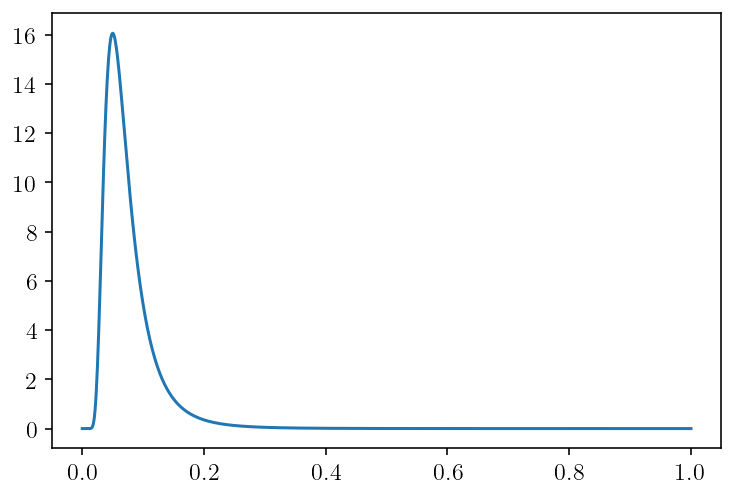

In [6]:
# Priors on rho_j
# mu_mean = 0.1856
# mu_sig2 = 1.0 / 0.5
# sig2_alpha = 3.0
# sig2_beta = 3.0
mu_mean = 0.1856
mu_sig2 = 0.05
sig2_alpha = 5.0
sig2_beta = 0.3
sig2_dist = scipy.stats.invgamma(sig2_alpha, scale=sig2_beta)

plt_vs = np.linspace(0, 1, 1000)
pdf = sig2_dist.pdf(plt_vs)
plt.plot(plt_vs, pdf)
plt.show()


In [7]:
# What is the support of the prior? (Much nicer than the Berry prior!)
sig2_dist.ppf([0.0000001, 0.999, 0.99999])


array([0.01147018, 0.40574989, 1.10057506])

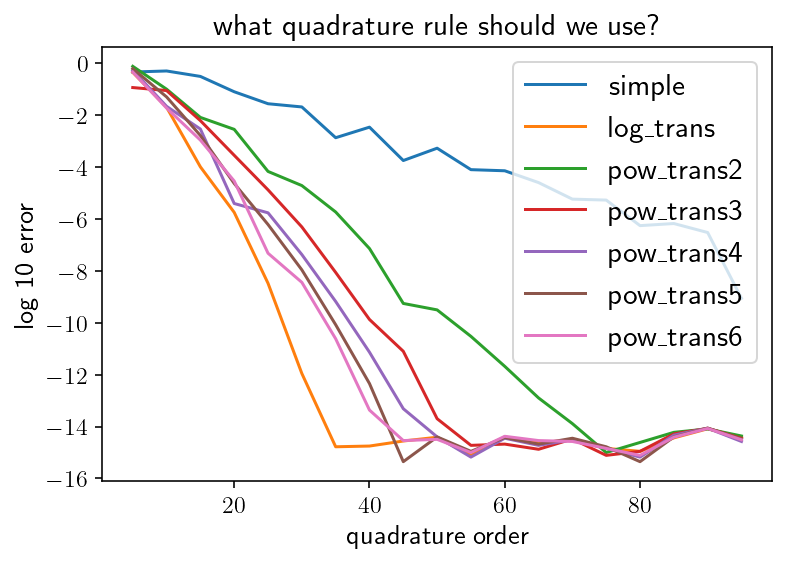

In [8]:
left = sig2_dist.ppf(1e-6) / 2
left_quantile = sig2_dist.cdf(left)
right_quantile = 1.0 - 1e-7
right = sig2_dist.ppf(right_quantile)
true_integral = right_quantile - left_quantile


def pow_gauss_rule(N, a, b, pow):
    A = (a) ** (1.0 / pow)
    B = (b) ** (1.0 / pow)
    qr = util.gauss_rule(N, a=A, b=B)
    pts = qr.pts**pow
    wts = pow * qr.pts ** (pow - 1) * qr.wts
    return util.QuadRule(pts, wts)


rules = dict(
    simple=util.gauss_rule,
    log_trans=util.log_gauss_rule,
)
for pow in [2, 3, 4, 5, 6]:
    rules[f"pow_trans{pow}"] = lambda N, a, b, pow=pow: pow_gauss_rule(N, a, b, pow)
orders = np.arange(5, 100, 5)
err = {k: [] for k in rules}
for i in orders:
    for k in rules:
        qr = rules[k](i, left, right)
        pdf = sig2_dist.pdf(qr.pts)
        quad = np.sum(pdf * qr.wts)
        err[k].append(quad - true_integral)

for k in rules:
    plt.plot(orders, np.log10(np.abs(err[k])), label=k)
plt.legend()
plt.title("what quadrature rule should we use?")
plt.ylabel("log 10 error")
plt.xlabel("quadrature order")
plt.show()


In [9]:
# 15 points with the log transformation should probably be good enough but we might consider 20 points.
orders[2], err["log_trans"][2], orders[3], err["log_trans"][3]


(15, -0.0001019743172334664, 20, 1.7947902204440425e-06)

In [40]:
20, left, right

(20, 0.006401632420120484, 2.8421994410275007)

In [10]:
qr_sigma2 = util.log_gauss_rule(20, left, right)

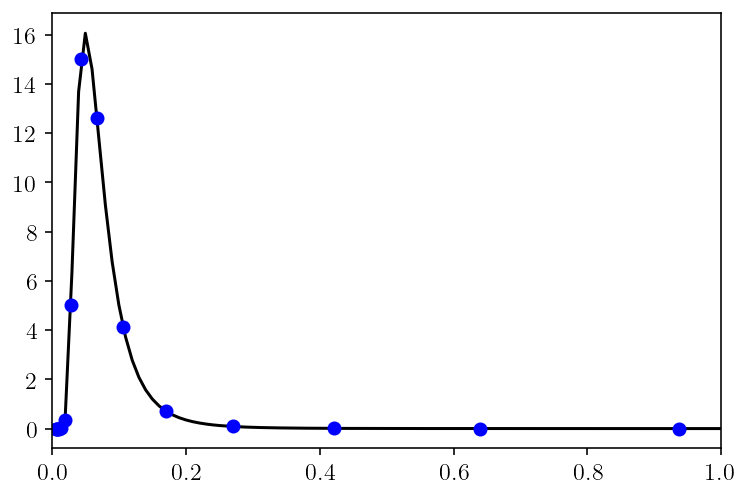

In [11]:
# But the distribution of points is still pretty obviously suboptimal, with too
# many points out in the two tails and too few points in the steep area.
plt_vs = np.linspace(0, 10, 1000)
pdf = sig2_dist.pdf(plt_vs)
plt.plot(plt_vs, pdf, "k")
plt.plot(qr_sigma2.pts, sig2_dist.pdf(qr_sigma2.pts), "bo")
plt.xlim([0, 1])
plt.show()


**I could design optimal quadrature rule for the known prior?!**

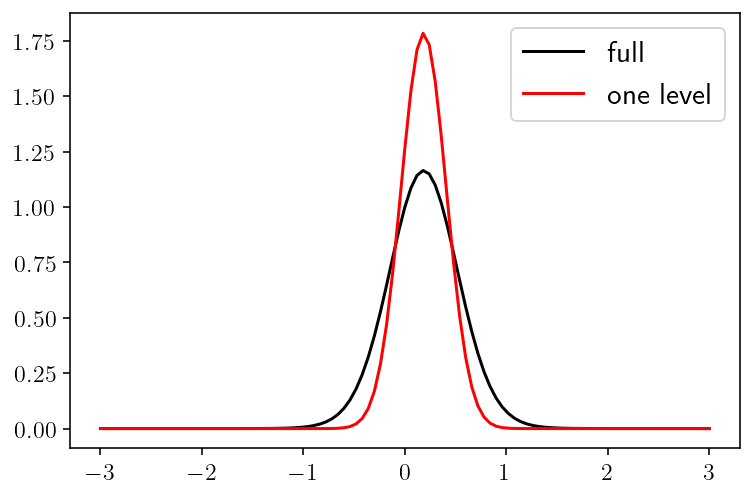

In [12]:
rho_range = [-3, 3]
mu_qr = util.simpson_rule(101, *rho_range)
mu_vs = mu_qr.pts
rho_sig2_pdf = scipy.stats.norm.pdf(
    mu_vs[:, None], mu_mean, np.sqrt(mu_sig2 + qr_sigma2.pts[None, :])
)
rho_pdf = np.sum(
    rho_sig2_pdf * (sig2_dist.pdf(qr_sigma2.pts) * qr_sigma2.wts)[None], axis=1
)
rho_pdf2 = scipy.stats.norm.pdf(mu_vs, mu_mean, np.sqrt(mu_sig2))
plt.plot(mu_vs, rho_pdf, "k-", label="full")
plt.plot(mu_vs, rho_pdf2, "r-", label="one level")
plt.legend()
plt.show()


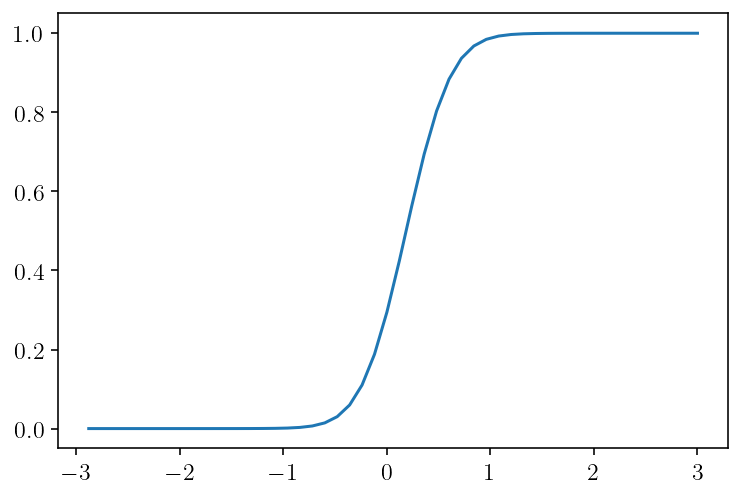

In [13]:
cdf = []
for i in range(3, mu_qr.pts.shape[0] + 1, 2):
    cdf_wts = util.simpson_rule(i, rho_range[0], mu_qr.pts[i - 1]).wts
    cdf.append((rho_pdf[:i] * cdf_wts).sum())
cdf = np.array(cdf)
cdf_pts = mu_qr.pts[2::2]
plt.plot(cdf_pts, cdf)
plt.show()


In [14]:
np.exp(cdf_pts[np.argmin(cdf < 0.025)]), np.exp(cdf_pts[np.argmax(cdf > 0.975)])


(0.6187833918061408, 2.611696473423118)

In [15]:
# check that the quadrature rule is working correctly.
correct = np.sin(rho_range[1]) - np.sin(rho_range[0])
test = (np.cos(mu_vs) * mu_qr.wts).sum()
test - correct, test

(2.032999385503942e-08, 0.2822400364497283)

In [16]:
(rho_pdf * np.exp(mu_vs) * mu_qr.wts).sum()


1.2818893143294785

In [17]:
(mu_vs * rho_pdf * mu_qr.wts).sum()


0.18559961576261566

In [18]:
mu_mean, mu_sig2


(0.1856, 0.05)

There's some bad stuff going on with these priors:
* in the paper they state that $E(\exp(\rho_j)) = 1.25$. This is absolutely not true for the parameters provided in the WinBUGS appendix.
* in fact, that expectation does not converge for the parameters provided.

To deal with this, I re-tuned the hyperparameters using the suggestions given:
* $E(\exp(\rho_j)) = 1.25$
* $E(\exp(\rho_2) | \exp(\rho_1) = 1.5) = 1.275$

Below, we approximately demonstrate these suggestions. The match is not precise, but neither is sampling.

In [19]:
mu_mean = 0.1856
mu_sig2 = 0.05
sig2_alpha = 5.0
sig2_beta = 0.3
sig2_dist = scipy.stats.invgamma(sig2_alpha, scale=sig2_beta)
print(sig2_dist.mean(), sig2_dist.var())

0.075 0.0018749999999999997


In [20]:
def sample():
    mu = numpyro.sample("mu", dist.Normal(mu_mean, jnp.sqrt(mu_sig2)))
    sigma2 = numpyro.sample("sigma2", dist.InverseGamma(sig2_alpha, sig2_beta))
    # numpyro.sample("rho", dist.Normal(mu, jnp.sqrt(sigma2)))
    # with numpyro.plate("j", 3):
    #     numpyro.sample(f"rho", dist.Normal(mu, jnp.sqrt(sigma2)))
    rhos = []
    for j in range(3):
        rhos.append(numpyro.sample(f"rho{j}", dist.Normal(mu, jnp.sqrt(sigma2))))
    # tau = numpyro.sample("tau", dist.Gamma(sig2_alpha, sig2_beta))
    # numpyro.sample("rho", dist.Normal(mu, jnp.sqrt(1.0 / tau)))


seed = 10
n_samples = 100000
nuts_kernel = numpyro.infer.NUTS(sample)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    progress_bar=False,
    num_warmup=100,
    num_samples=n_samples,
    jit_model_args=True,
)
rng_key = jax.random.PRNGKey(seed)
mcmc.run(rng_key)
samples = mcmc.get_samples()

print("E(e^rho) = ", np.sum(np.exp(samples["rho0"]), axis=0) / n_samples)


E(e^rho) =  1.2781669409954448


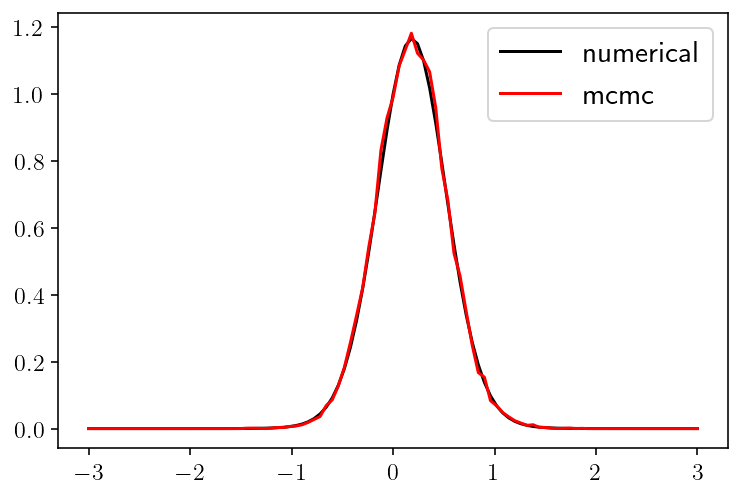

In [21]:
rho_kde = scipy.stats.gaussian_kde(samples["rho0"].to_py(), bw_method=0.01)(mu_qr.pts)
plt.plot(mu_qr.pts, rho_pdf, "k-", label="numerical")
plt.plot(mu_qr.pts, rho_kde, "r-", label="mcmc")
plt.legend()
plt.show()


In [22]:
ci025 = np.log(0.65)
ci975 = np.log(2.20)
np.mean(samples["rho0"] < ci025), np.mean(samples["rho0"] > ci975)


(DeviceArray(0.04021, dtype=float64), DeviceArray(0.04188, dtype=float64))

In [23]:
sample_conditional = numpyro.handlers.condition(sample, {"rho0": np.log(1.5)})
nuts_kernel = numpyro.infer.NUTS(sample_conditional)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    progress_bar=False,
    num_warmup=100,
    num_samples=n_samples,
    jit_model_args=True,
)
rng_key = jax.random.PRNGKey(seed)
mcmc.run(rng_key)
samples = mcmc.get_samples()

print(
    "E(e^rho_1 | e^rho_0 = 1.5) = ",
    np.exp(samples["rho1"].mean()),
    np.exp(samples["rho2"].mean()),
)


E(e^rho_1 | e^rho_0 = 1.5) =  1.3198780130544425 1.3264187485325898


## Simulating the trial

For now, I'm going to fix the values of $\lambda_j$ to simplify the design and extract the basic basket trial aspect.

In [1]:
import sys

sys.path.append("../imprint/research/berry/")
import berrylib.util as util

util.setup_nb()


In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
import numpyro.infer

import jax
import jax.numpy as jnp

from jax.config import config

# This line is critical for enabling 64-bit floats.
config.update("jax_enable_x64", True)


/Users/tbent/.mambaforge/envs/imprint/lib/python3.10/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/tbent/.mambaforge/envs/imprint/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mu_mean = 0.1856
mu_sig2 = 0.05
sig2_alpha = 5.0
sig2_beta = 0.3
alpha = [24, 66, 40]
beta = [416.3, 331, 234]

narms = 3
accrual_time = 24
npatients = 24 * 4
monitor_time = 12
total_time = accrual_time + monitor_time
accrual_rates = np.array([1, 2, 1])
accrual_prob = accrual_rates / accrual_rates.sum()

lambdaj = scipy.stats.invgamma.mean(alpha, scale=beta)


def simulate(ntrials, seed=None):
    if seed is not None:
        np.random.seed(seed)

    mu = scipy.stats.norm.rvs(mu_mean, np.sqrt(mu_sig2), size=ntrials)
    sig2 = scipy.stats.invgamma.rvs(sig2_alpha, scale=sig2_beta, size=ntrials)
    rho = scipy.stats.norm.rvs(
        mu[:, None], np.sqrt(sig2)[:, None], size=(ntrials, narms)
    )
    return simulate_known_rho(rho)


def simulate_known_rho(rho, seed=None):
    ntrials = rho.shape[0]
    if seed is not None:
        np.random.seed(seed)

    arm_multinomial = scipy.stats.multinomial.rvs(
        1, accrual_prob, size=(ntrials, npatients)
    )
    # arm_multinomial is (ntrials, npatients, narms)
    # arm_assignments is (ntrials, npatients) where the integer value indicates the arm assignment.
    arm_assignments = np.where(arm_multinomial)[2].reshape((ntrials, npatients))

    trial_index_per_patient = np.tile(np.arange(ntrials)[:, None], (1, npatients))
    rho_arm = rho[trial_index_per_patient, arm_assignments]
    lambda_arm = lambdaj[arm_assignments]
    # time to failure, aka 1/hazard
    time_to_failure = np.exp(rho_arm) * lambda_arm
    event_time = scipy.stats.expon.rvs(scale=time_to_failure)
    arrival_time = np.tile(
        np.linspace(0, accrual_time, npatients)[None, :], (ntrials, 1)
    )
    is_censored = np.where(event_time + arrival_time > total_time, True, False)
    censored_event_time = np.where(is_censored, total_time - arrival_time, event_time)
    return time_to_failure, arrival_time, is_censored, censored_event_time, arm_assignments


ntrials = 5000
rho = np.zeros((ntrials, narms))
true_ttf, arrival_time, is_censored, event_time, arm_assignments = simulate_known_rho(rho, seed=None)
for arm_idx in range(3):
    print(arm_idx, event_time[arm_assignments == arm_idx].mean(), lambdaj[arm_idx])


0 12.928554414258716 18.1
1 4.976793910133395 5.092307692307693
2 5.8202525206886175 6.0


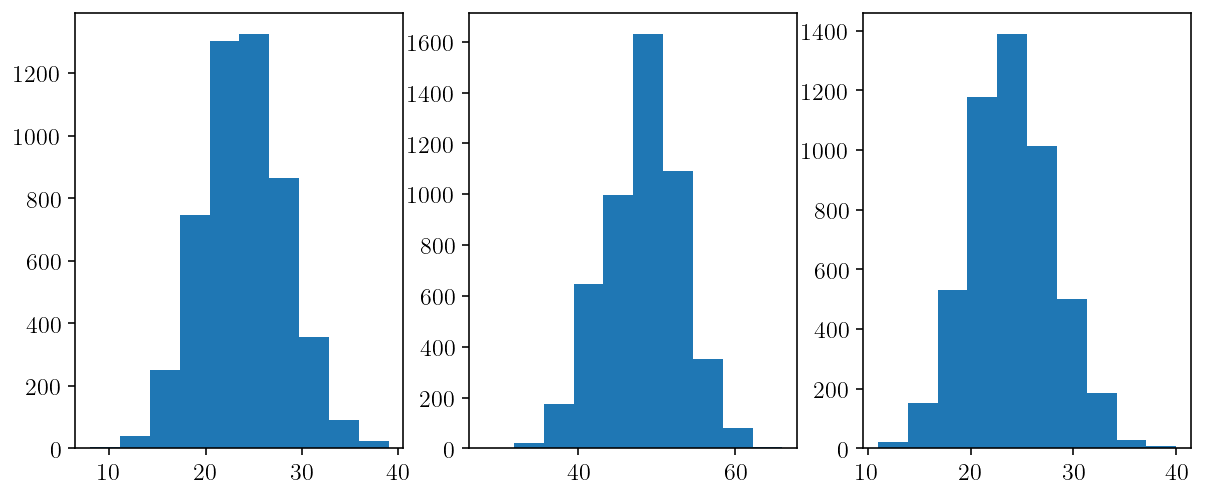

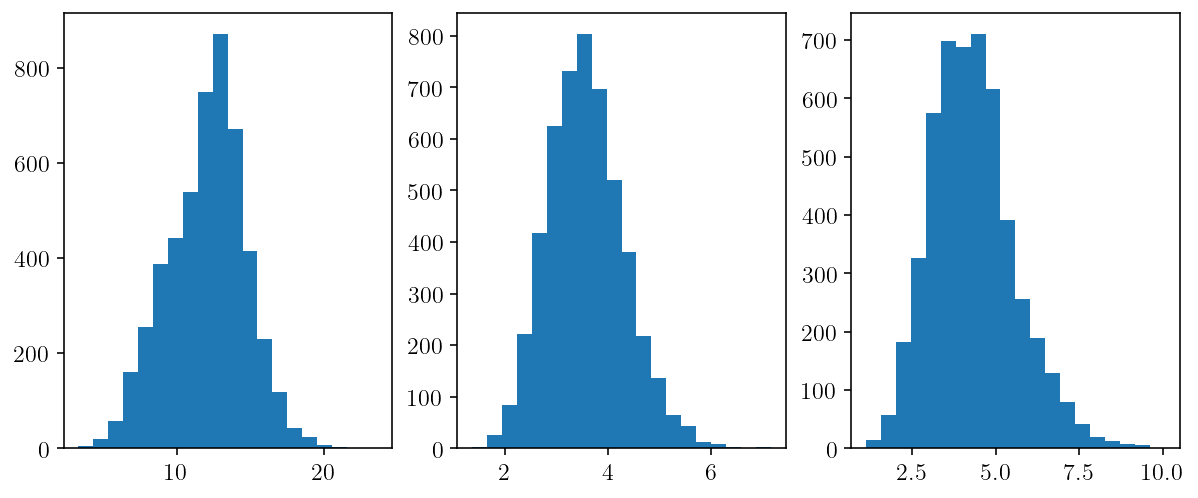

In [4]:
# simulate under the null that the treatment has no effect. the time to failure
# multiplier is np.exp(rho), so rho = 0 results in a failure multiplier of 1.0
# leading to hazard equal to that under past treatment.
null_rho = np.tile(np.array([0.0, 0.0, 0.0])[None, :], (ntrials, 1))

true_hazard, arrival_time, is_censored, event_time, arm_assignments = simulate_known_rho(null_rho)
median_event_times = np.empty((ntrials, narms))
npatients_per_arm = np.empty((ntrials, narms), dtype=int)
for i in range(ntrials):
    for arm_idx in range(3):
        median_event_times[i, arm_idx] = np.median(event_time[i, arm_assignments[i,:] == arm_idx])
        npatients_per_arm[i, arm_idx] = np.sum(arm_assignments[i,:] == arm_idx)
plt.figure(figsize=(10,4))
for i in range(3):
    plt.subplot(1,3,1 + i)
    plt.hist(npatients_per_arm[:,i])
plt.show()
plt.figure(figsize=(10,4))
for i in range(3):
    plt.subplot(1,3,1 + i)
    plt.hist(median_event_times[:,i], bins=20)
plt.show()

Event time quantiles are lower than the expected time to event because they are censored.

In [5]:
for j in range(3):
    print(lambdaj[j], np.quantile(median_event_times[:,j], [0.25, 0.5, 0.75]))

18.1 [10.22922463 12.25448491 13.77395091]
5.092307692307693 [3.0368547  3.52084322 4.04324205]
6.0 [3.41676915 4.21492547 5.03142451]


In [6]:
def construct_suff_stats(cur_time, arrival_time, is_censored, event_time, arm_assignments):
    cur_arm_assigns = arm_assignments.copy()
    cur_arm_assigns[arrival_time > cur_time] = -1
    cur_is_censored = is_censored | ((event_time + arrival_time) > cur_time)
    cur_event_time = np.where(cur_is_censored, cur_time - arrival_time, event_time)

    ntrials = arrival_time.shape[0]

    n_events = np.empty((ntrials, narms))
    total_obs_time = np.empty((ntrials, narms))
    n_patients = np.empty((ntrials, narms))
    for i in range(ntrials):
        for j in range(narms):
            this_arm = cur_arm_assigns[i, :] == j
            n_events[i,j] = np.sum(np.where(~cur_is_censored[i, this_arm], 1, 0))
            total_obs_time[i,j] = np.sum(cur_event_time[i, this_arm])
            n_patients[i, j] = np.sum(this_arm)
    return np.stack((n_events, total_obs_time, n_patients), axis=-1)

suff_stats = construct_suff_stats(36, arrival_time, is_censored, event_time, arm_assignments)

In [7]:
suff_stats[:5]

array([[[ 25.        , 490.89548468,  36.        ],
        [ 39.        , 183.41089701,  39.        ],
        [ 21.        , 107.54346258,  21.        ]],

       [[ 10.        , 152.26894019,  14.        ],
        [ 53.        , 261.23897772,  54.        ],
        [ 27.        , 152.26414374,  28.        ]],

       [[ 18.        , 369.28472027,  26.        ],
        [ 46.        , 212.84069198,  49.        ],
        [ 19.        , 148.14065553,  21.        ]],

       [[ 18.        , 210.0785012 ,  21.        ],
        [ 50.        , 204.16873612,  50.        ],
        [ 22.        , 173.38630434,  25.        ]],

       [[ 22.        , 310.68145259,  28.        ],
        [ 40.        , 187.71201704,  41.        ],
        [ 27.        , 160.52423086,  27.        ]]])

In [7]:
class CensoredExponential(dist.Distribution):
    def __init__(self, hazard, validate_args=None):
        self.hazard = hazard
        self.log_hazard = jnp.log(hazard)
        super(CensoredExponential, self).__init__(
            batch_shape=jnp.shape(hazard), validate_args=validate_args
        )

    def sample(self, key):
        raise NotImplementedError()

    def log_prob(self, suff_stats):
        n_events, total_obs_time, _ = suff_stats
        return self.log_hazard * n_events - self.hazard * total_obs_time

def sample(suff_stats):
    mu = numpyro.sample("mu", dist.Normal(mu_mean, jnp.sqrt(mu_sig2)))
    sigma2 = numpyro.sample("sigma2", dist.InverseGamma(sig2_alpha, sig2_beta))
    for j in range(narms):
        rhoj = numpyro.sample(f"rho{j}", dist.Normal(mu, jnp.sqrt(sigma2)))
        numpyro.sample(
            f"x{j}",
            CensoredExponential(1.0 / (jnp.exp(rhoj) * lambdaj[j])),
            obs=suff_stats[j],
        )

In [8]:
n_samples = 100000
kernel = numpyro.infer.NUTS(sample)
mcmc = numpyro.infer.MCMC(
    kernel,
    progress_bar=False,
    num_warmup=100,
    num_samples=n_samples,
    jit_model_args=True,
)
rng_key = jax.random.PRNGKey(10)

In [9]:
def mcmc_run(mcmc, suff_stats):
    mcmc.run(rng_key, suff_stats)
    samples = mcmc.get_samples()
    rho_samples = np.empty((n_samples, narms))
    for j in range(3):
        rho_samples[:, j] = samples[f'rho{j}']
    return samples, rho_samples

In [10]:
# stop = 0
# risky = 0
# for i in range(100):
#     mcmc_run(suff_stats[i])
#     prob_erho_above = np.sum(np.exp(rho_samples) > 1.5, axis=0) / n_samples
#     if np.all(prob_erho_above < 0.075):
#         stop += 1
#     if np.any(prob_erho_above > 0.5):
#         risky += 1
# print(stop, risky)

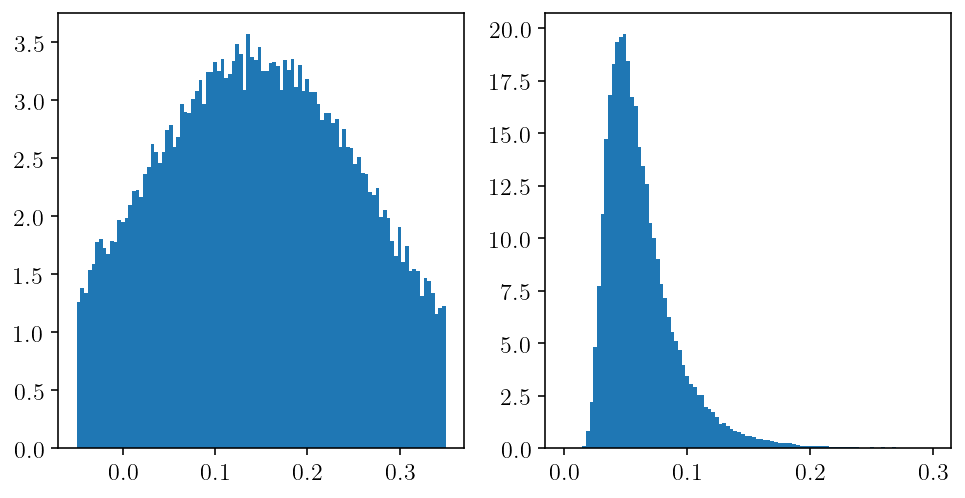

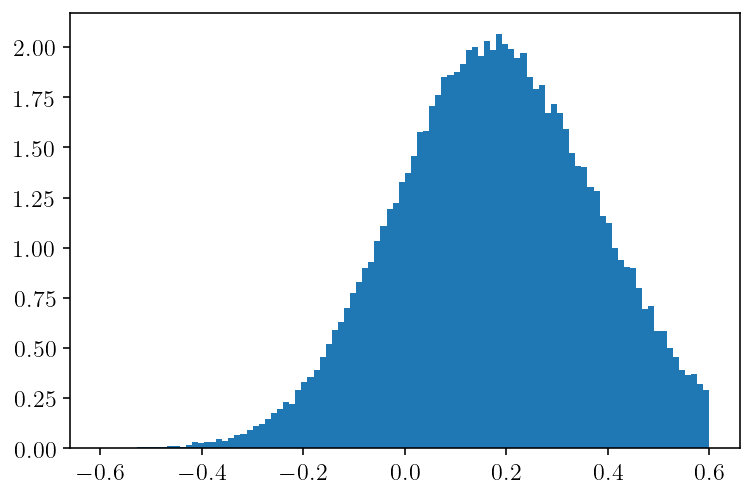

(DeviceArray(0.14439013, dtype=float64),
 DeviceArray(0.06374931, dtype=float64),
 array([0.18755482, 0.09070847, 0.10585245]))

In [11]:
samples, rho_samples = mcmc_run(mcmc, suff_stats[0])
mu_samples = samples['mu']
sig2_samples = samples['sigma2']
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(mu_samples, bins=np.linspace(-0.05, 0.35, 101), density=True)
plt.subplot(1, 2, 2)
plt.hist(sig2_samples, bins=np.linspace(0, 0.3, 101), density=True)
plt.show()
plt.hist(rho_samples[:,0], density=True, bins=np.linspace(-0.6, 0.6, 101))
plt.show()
mu_samples.mean(), sig2_samples.mean(), rho_samples.mean(axis=0)

In [12]:
@jax.jit
def log_joint(data, rho, neg_precQ, logprecQdet, log_prior):
    """
    theta is expected to have shape (N, n_sigma2, n_arms)
    """
    n_events = data[..., 0]
    total_obs_time = data[..., 1]
    rho_m0 = rho - mu_mean
    hazard = 1.0 / (jnp.exp(rho) * lambdaj[None])
    return (
        0.5 * jnp.einsum("...i,...ij,...j", rho_m0, neg_precQ, rho_m0)
        + logprecQdet
        + jnp.sum(
            jnp.log(hazard) * n_events[:, None] - hazard * total_obs_time[:, None],
            axis=-1,
        )
        + log_prior
    )


def scalar_log_joint_opt(rho, neg_precQ, n_events, total_obs_time):
    """
    theta is expected to have shape (N, n_sigma2, n_arms)
    """
    rho_m0 = rho - mu_mean
    hazard = 1.0 / (jnp.exp(rho) * lambdaj)
    return 0.5 * neg_precQ.dot(rho_m0).T.dot(rho_m0) + jnp.sum(
        jnp.log(hazard) * n_events - hazard * total_obs_time
    )


grad_opt = jax.jit(
    jax.vmap(
        jax.vmap(jax.grad(scalar_log_joint_opt), in_axes=(0, 0, None, None)),
        in_axes=(0, None, 0, 0),
    )
)
hessian_opt = jax.jit(
    jax.vmap(
        jax.vmap(jax.hessian(scalar_log_joint_opt), in_axes=(0, 0, None, None)),
        in_axes=(0, None, 0, 0),
    )
)

def grad_hess(fi, data, rho, arms_opt):
    grad = grad_opt(rho, fi.neg_precQ, data[..., 0], data[..., 1])
    hess = hessian_opt(rho, fi.neg_precQ, data[..., 0], data[..., 1])
    return grad, hess


import berrylib.fast_inla as fast_inla

def log_joint_wrapper(fi, data, rho):
    return log_joint(data, rho, fi.neg_precQ, fi.logprecQdet, fi.log_prior)

model = fast_inla.FastINLAModel(log_joint_wrapper, grad_hess)
fi = fast_inla.FastINLA(
    model=model,
    n_arms=3,
    mu_0=mu_mean,
    mu_sig2=mu_sig2,
    sigma2_n=20,
    sigma2_bounds=[0.006401632420120484, 2.8421994410275007],
    sigma2_alpha=sig2_alpha,
    sigma2_beta=sig2_beta,
)

In [13]:
np_inference = fi.numpy_inference(suff_stats, thresh_theta=np.repeat(np.log(1.0), 3))

In [14]:
np.sum(np.any(np_inference[1] > 0.95, axis=1)) / np_inference[1].shape[0]

0.0902

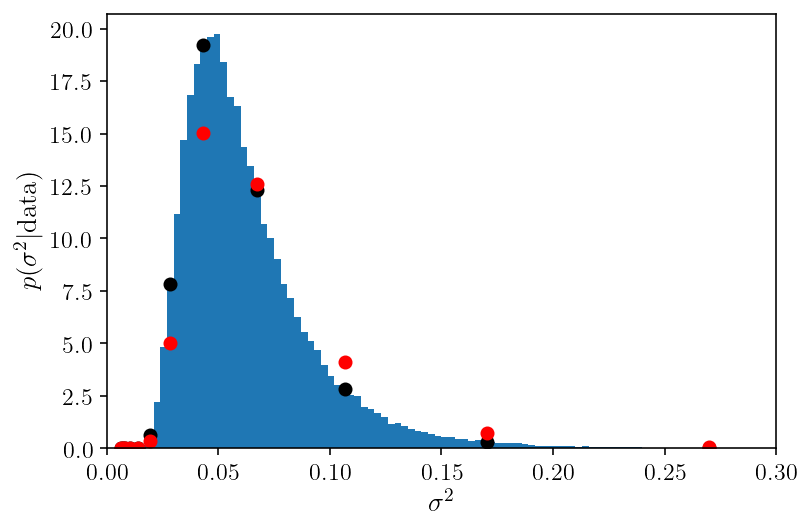

In [15]:
plt.plot(fi.sigma2_rule.pts, np_inference[0][0], 'ko')
plt.plot(fi.sigma2_rule.pts, np.exp(fi.log_prior), 'ro')
plt.hist(sig2_samples, bins=np.linspace(0, 0.3, 101), density=True)
plt.xlim([0, 0.3])
plt.ylabel('$p(\sigma^2 | \mathrm{data})$')
plt.xlabel('$\sigma^2$')
plt.show()

i-th patient j-th arm

Each arm treat a different condition with the same treatment.

$\lambda_j$ is the historical mean survival time for patients with condition $j$. In the paper, they actually give distributions for $\lambda_j$. I just took the mean of those distributions.

$x_{ij} \sim \mathrm{censoredexponential}(\gamma_j, \mathrm{observation~time})$

$\gamma_j = \lambda_j exp(\rho_j)$

$h = 1 / t_j$

Sharing between arms since we think the treatment should work similarly for each condition:
$\rho_j \sim N(\mu, \sigma^2)$

Mean of the sharing distribution.
$\mu \sim N(\mu_0, \mu_{\sigma})$

$\sigma^2 \sim \mathrm{InvGamma}(\alpha, \beta)$

Get rid of $\mu$:
$\rho_j \sim N(\mu_0, \mu_{\sigma}I + \sigma^2 J)$

dataset 0


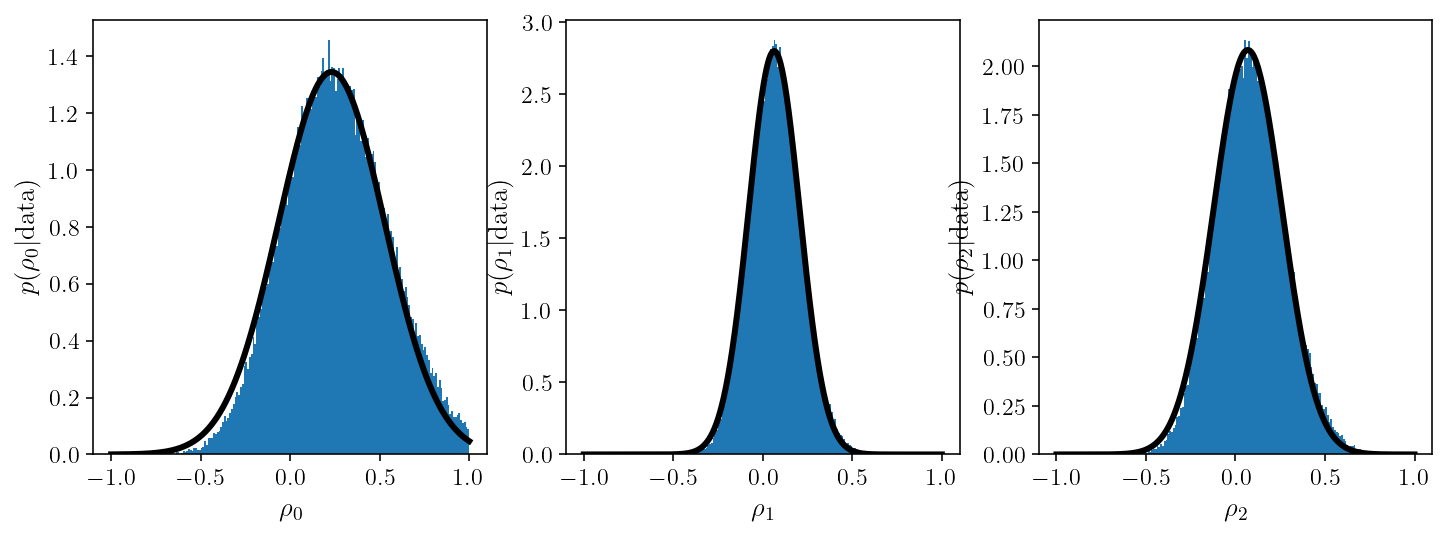

dataset 1


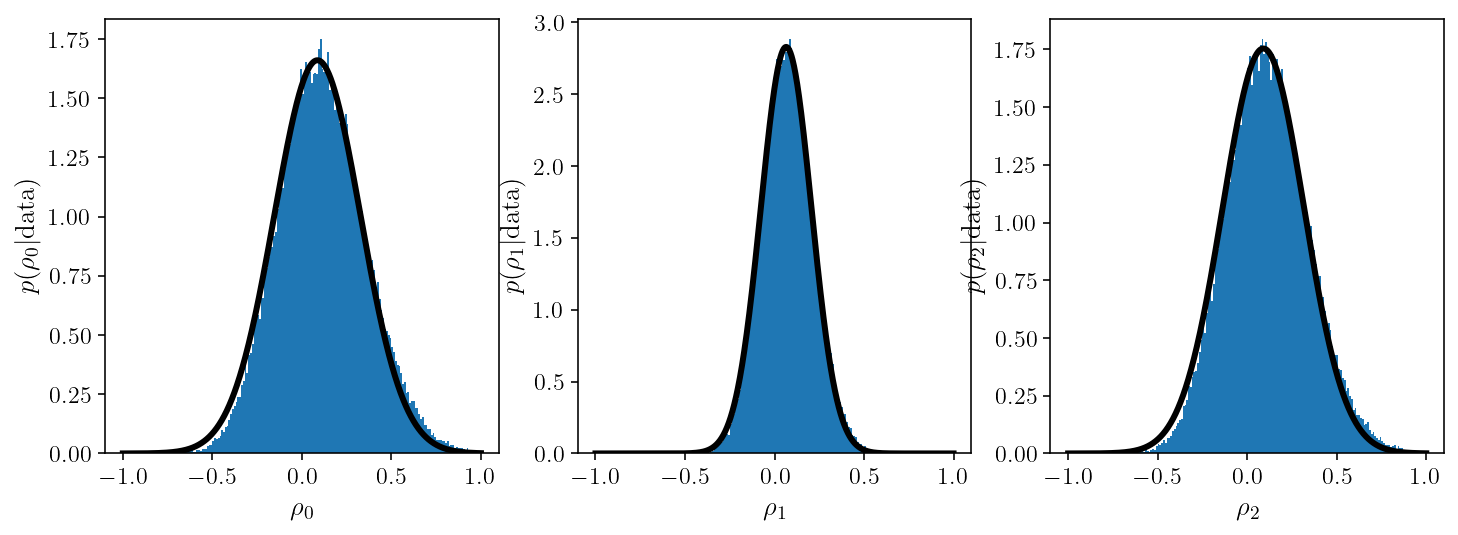

dataset 2


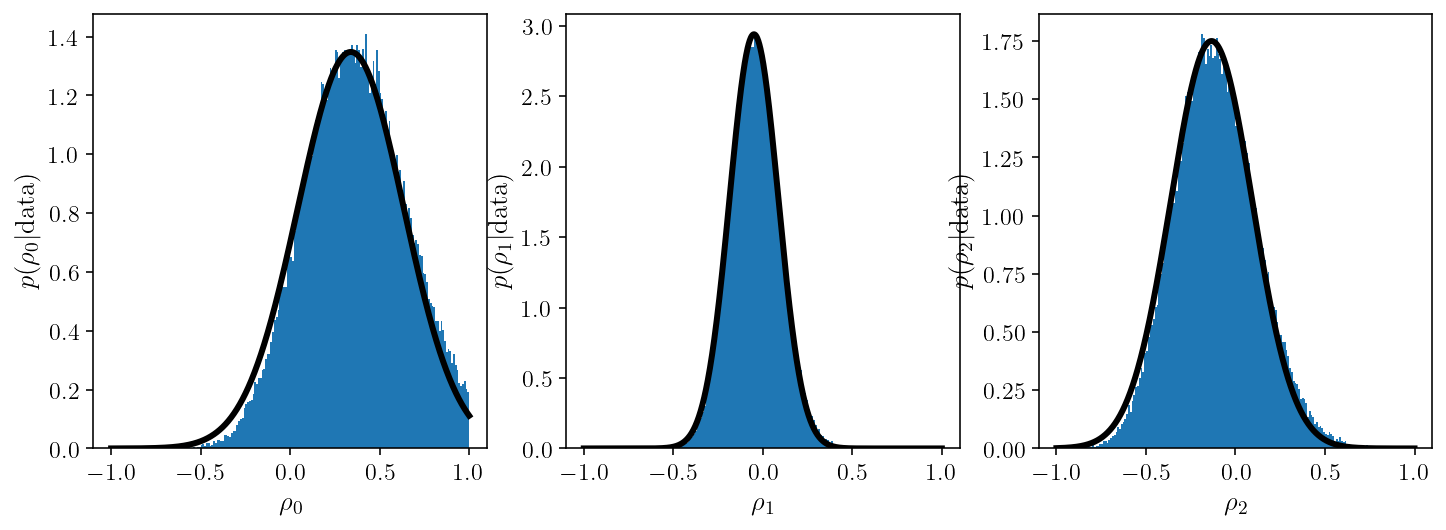

In [16]:
sample_fixed_sigma2 = numpyro.handlers.condition(sample, dict(sigma2=2.7832934704550967))
n_samples = 100000
kernel = numpyro.infer.NUTS(sample_fixed_sigma2)
mcmc_fixed_sigma2 = numpyro.infer.MCMC(
    kernel,
    progress_bar=False,
    num_warmup=100,
    num_samples=n_samples,
    jit_model_args=True,
)
for i in range(3):
    print(f'dataset {i}')
    samples_fixed, rho_samples_fixed = mcmc_run(mcmc_fixed_sigma2, suff_stats[i])
    theta_max = np_inference[2][i]
    theta_sigma = np_inference[3][i]
    plt.figure(figsize=(12, 4))
    plt_vs = np.linspace(-1, 1, 1000)
    for j in range(3):
        plt.subplot(1, 3, 1 + j)
        plt.hist(rho_samples_fixed[:, j], density=True, bins=np.linspace(-1.0, 1.0, 201))
        plt.plot(plt_vs, scipy.stats.norm.pdf(plt_vs, theta_max[-1, j], theta_sigma[-1, j]), 'k-', linewidth=3)
        plt.ylabel(f'$p(\\rho_{j}' + ' | \mathrm{data})$')
        plt.xlabel(f'$\\rho_{j}$')
    plt.show()

## I want to test small N.

In [128]:
ts = np.linspace(0, 36, 2000)
suff_stats = []
for t in ts:
    suff_stats.append(construct_suff_stats(t, arrival_time[:1], is_censored[:1], event_time[:1], arm_assignments[:1])[0])

In [129]:
suff_stats = np.array(suff_stats)
suff_stats.shape

(2000, 3, 3)

In [130]:
np_inference = fi.numpy_inference(suff_stats, thresh_theta=np.repeat(np.log(1.5), 3))

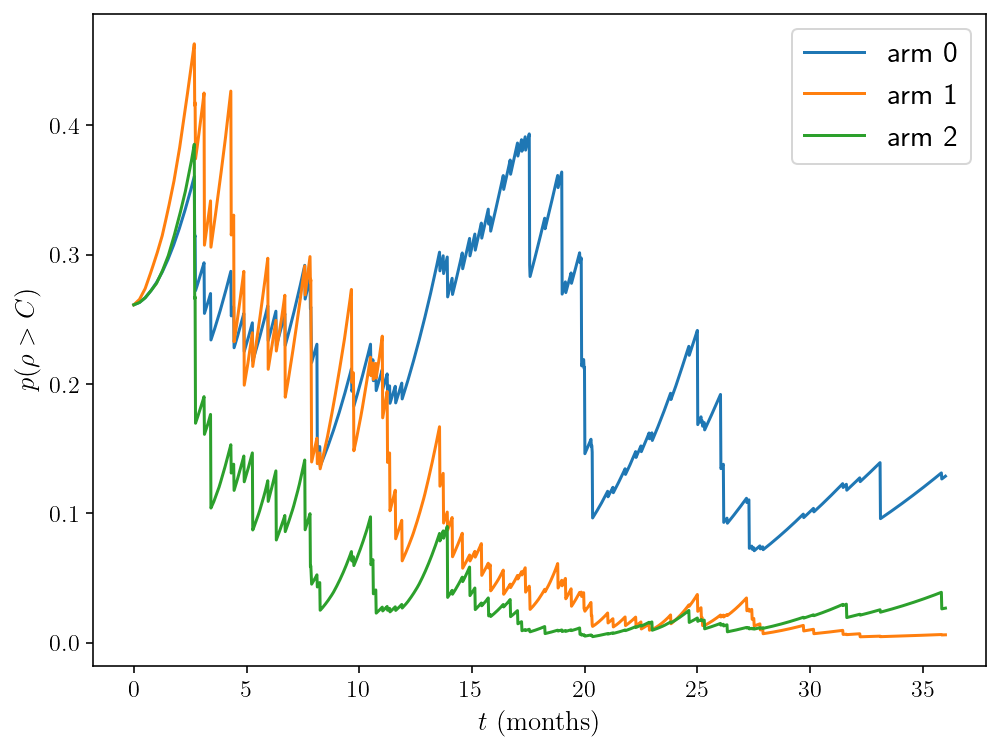

In [131]:
plt.figure(figsize=(8,6))
for j in range(3):
    plt.plot(ts, np_inference[1][:,j], label=f'arm {j}')
plt.xlabel('$t ~ \mathrm{(months)}$')
plt.ylabel(f'$p(\\rho > C)$')
plt.legend()
plt.show()

In [132]:
samples, rho_samples = mcmc_run(mcmc, suff_stats[5])

In [133]:
np.sum(rho_samples[:,:] > np.log(1.5), axis=0) / rho_samples.shape[0], np_inference[1][5]

(array([0.25788, 0.25948, 0.26063]),
 array([0.26190432, 0.26274118, 0.26190432]))

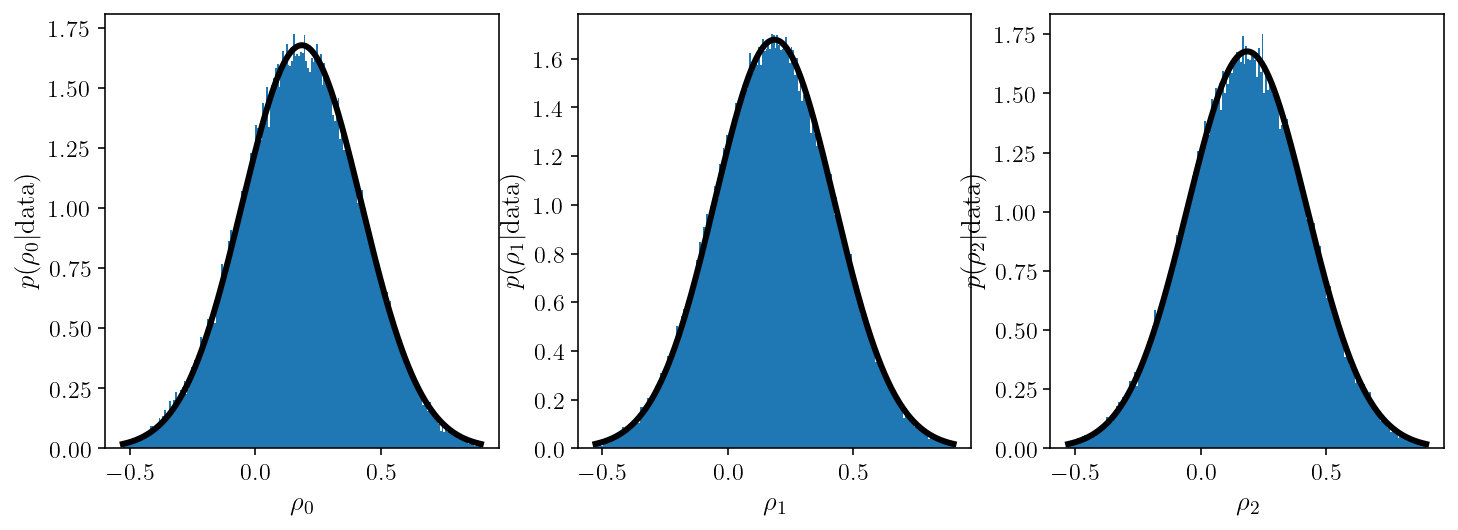

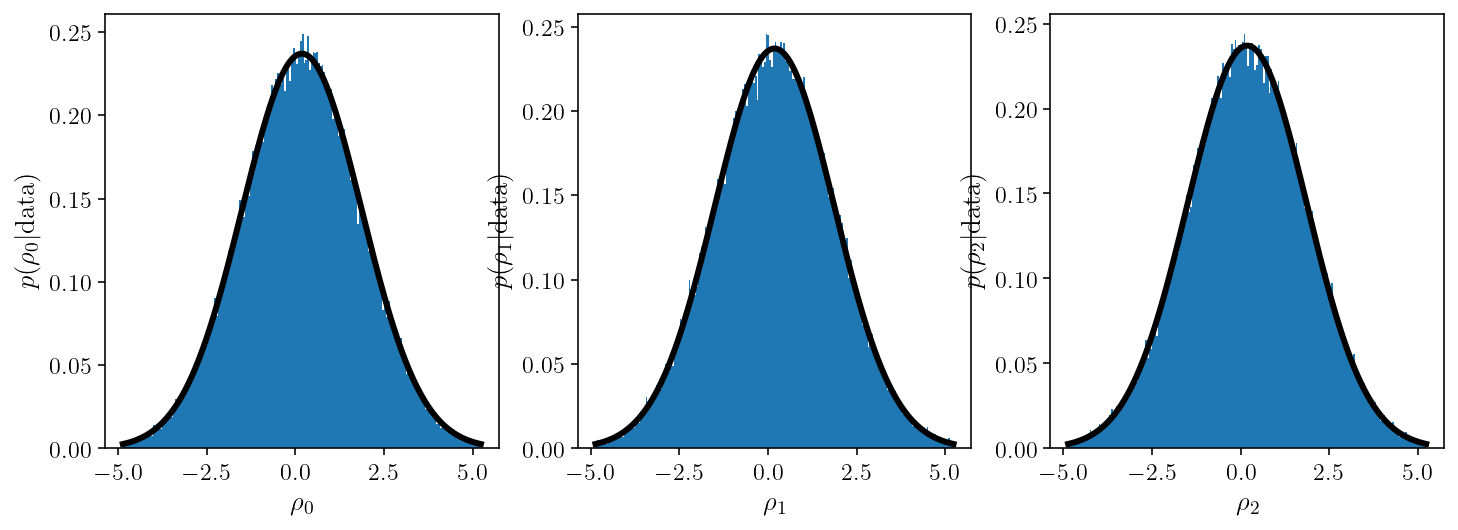

In [134]:
i = 0
for sig_idx in [0, -1]:#range(0, 20, 3):
    sample_fixed_sigma2 = numpyro.handlers.condition(sample, dict(sigma2=fi.sigma2_rule.pts[sig_idx]))
    n_samples = 100000
    kernel = numpyro.infer.NUTS(sample_fixed_sigma2)
    mcmc_fixed_sigma2 = numpyro.infer.MCMC(
        kernel,
        progress_bar=False,
        num_warmup=100,
        num_samples=n_samples,
        jit_model_args=True,
    )
    samples_fixed, rho_samples_fixed = mcmc_run(mcmc_fixed_sigma2, suff_stats[i])
    theta_max = np_inference[2][i]
    theta_sigma = np_inference[3][i]
    plt.figure(figsize=(12, 4))
    for j in range(3):
        plt.subplot(1, 3, 1 + j)
        vmin = theta_max[sig_idx, j] - 3 * theta_sigma[sig_idx, j]
        vmax = theta_max[sig_idx, j] + 3 * theta_sigma[sig_idx, j]
        plt_vs = np.linspace(vmin, vmax, 1000)
        plt.hist(rho_samples_fixed[:, j], density=True, bins=np.linspace(vmin, vmax, 201))
        # plt.vlines([theta_max[sig_idx, j]], [0], [1], colors='k', linestyles='solid')
        plt.plot(plt_vs, scipy.stats.norm.pdf(plt_vs, theta_max[sig_idx, j], theta_sigma[sig_idx, j]), 'k-', linewidth=3)
        plt.ylabel(f'$p(\\rho_{j}' + ' | \mathrm{data})$')
        plt.xlabel(f'$\\rho_{j}$')
    plt.show()

In [135]:
hess = np.linalg.inv(np_inference[-1])

In [138]:
dethess = np.linalg.det(hess)

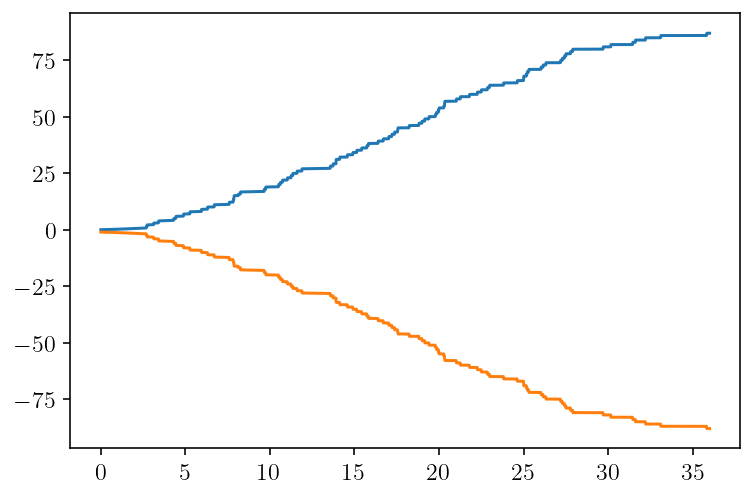

In [136]:
sig_idx = -1
third_tensor = jax.vmap(jax.jacrev(jax.hessian(scalar_log_joint_opt)), in_axes=(0, None, 0, 0))(
    jnp.array(np_inference[2][:, sig_idx]),
    jnp.array(fi.neg_precQ[sig_idx]),
    jnp.array(suff_stats[:, ..., 0]),
    jnp.array(suff_stats[:, ..., 1]),
)
third_tensor.shape

In [143]:
prod3 = third_tensor[:,0,0,0] * third_tensor[:,1,1,1] * third_tensor[:,2,2,2]

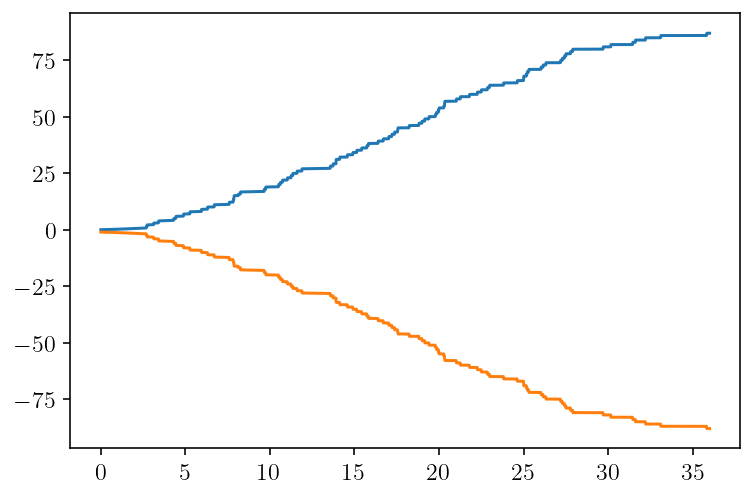

In [144]:
traces = np.trace(hess[:, sig_idx,:,:], axis1=1, axis2=2)
plt.plot(ts, third_tensor.sum(axis=(1,2,3)))
plt.plot(ts, traces)
plt.show()

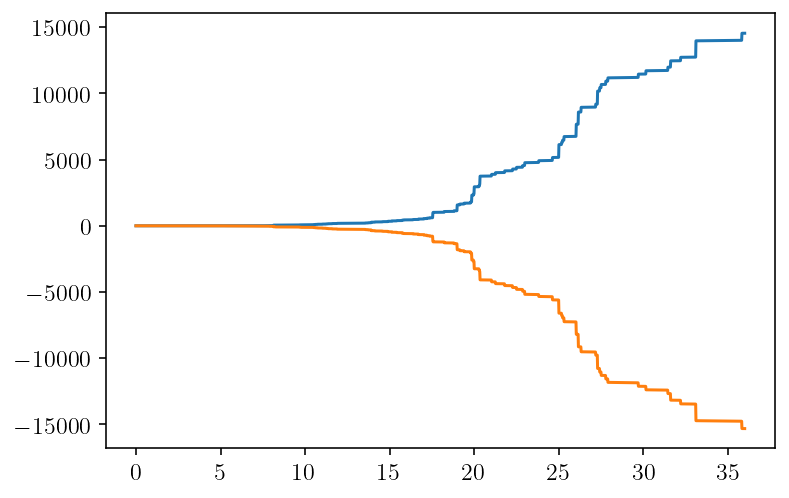

In [148]:
plt.plot(ts, prod3)
plt.plot(ts, dethess[:,sig_idx])
plt.show()

## No events?

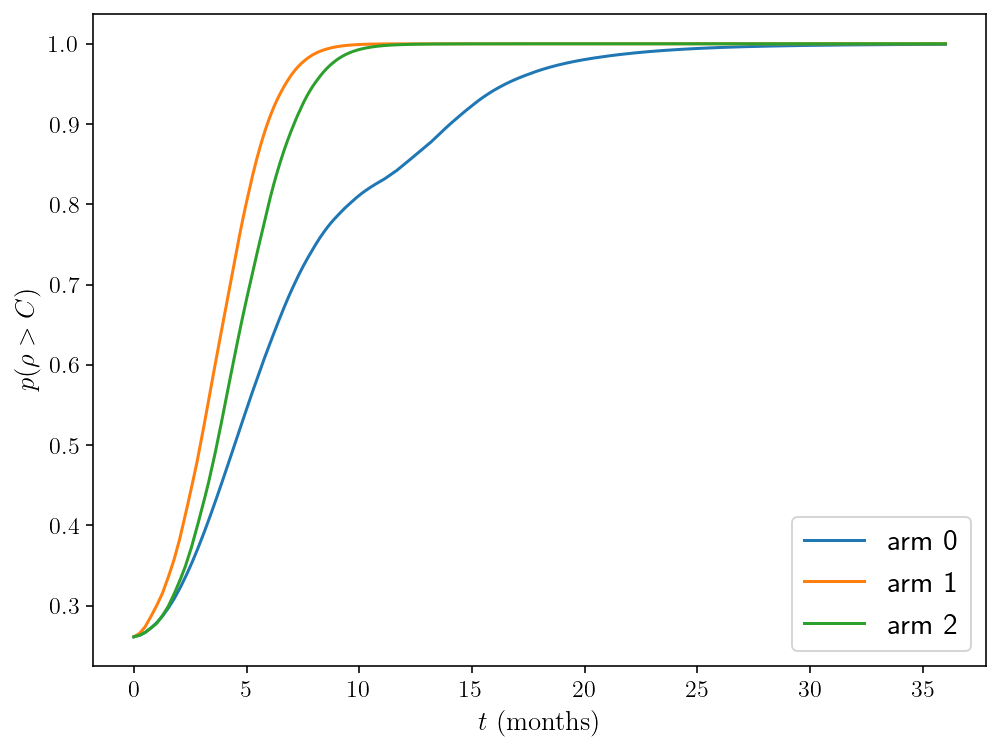

In [149]:
zero_is_censored = np.ones(96, dtype=bool)
zero_arrival_time = arrival_time[:1]
zero_event_time = 36 - arrival_time[:1]
zero_arms = arm_assignments[:1]

ts = np.linspace(0, 36, 2000)
suff_stats = []
for t in ts:
    suff_stats.append(construct_suff_stats(t, zero_arrival_time, zero_is_censored, zero_event_time, zero_arms)[0])
suff_stats = np.array(suff_stats)
np_inference = fi.numpy_inference(suff_stats, thresh_theta=np.repeat(np.log(1.5), 3))

plt.figure(figsize=(8,6))
for j in range(3):
    plt.plot(ts, np_inference[1][:,j], label=f'arm {j}')
plt.xlabel('$t ~ \mathrm{(months)}$')
plt.ylabel(f'$p(\\rho > C)$')
plt.legend()
plt.show()

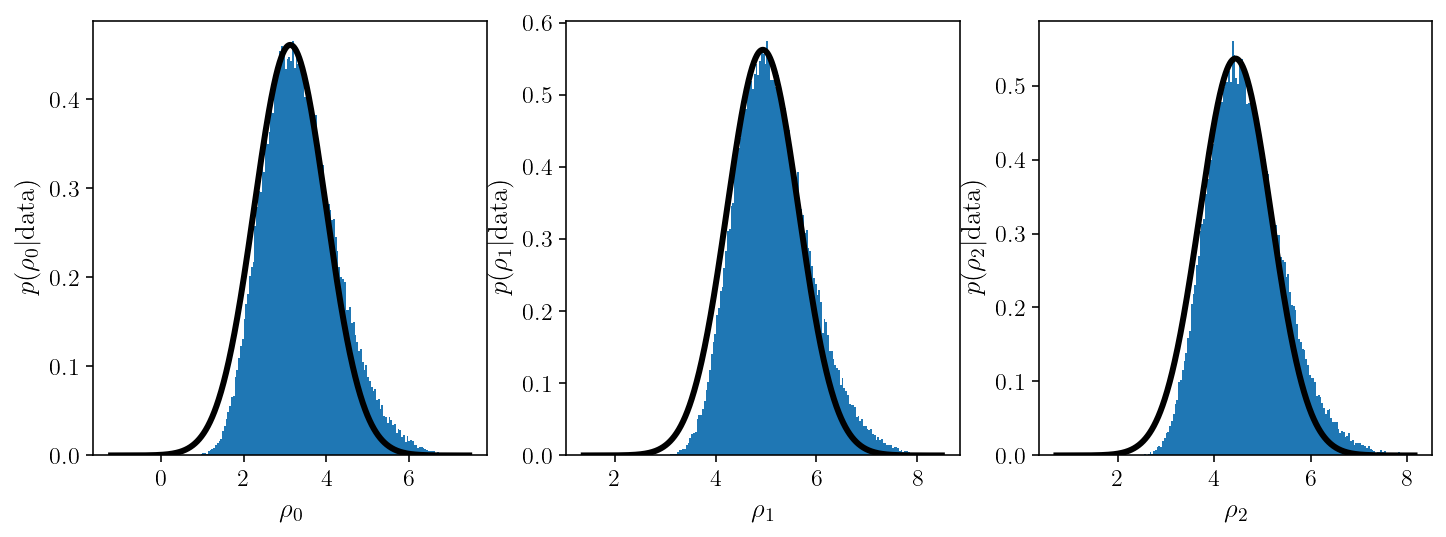

In [150]:
i = -1
for sig_idx in [19]:#range(0, 20, 3):
    sample_fixed_sigma2 = numpyro.handlers.condition(sample, dict(sigma2=fi.sigma2_rule.pts[sig_idx]))
    n_samples = 100000
    kernel = numpyro.infer.NUTS(sample_fixed_sigma2)
    mcmc_fixed_sigma2 = numpyro.infer.MCMC(
        kernel,
        progress_bar=False,
        num_warmup=100,
        num_samples=n_samples,
        jit_model_args=True,
    )
    samples_fixed, rho_samples_fixed = mcmc_run(mcmc_fixed_sigma2, suff_stats[i])
    theta_max = np_inference[2][i]
    theta_sigma = np_inference[3][i]
    plt.figure(figsize=(12, 4))
    for j in range(3):
        plt.subplot(1, 3, 1 + j)
        vmin = theta_max[sig_idx, j] - 5 * theta_sigma[sig_idx, j]
        vmax = theta_max[sig_idx, j] + 5 * theta_sigma[sig_idx, j]
        plt_vs = np.linspace(vmin, vmax, 1000)
        plt.hist(rho_samples_fixed[:, j], density=True, bins=np.linspace(vmin, vmax, 201))
        # plt.vlines([theta_max[sig_idx, j]], [0], [1], colors='k', linestyles='solid')
        plt.plot(plt_vs, scipy.stats.norm.pdf(plt_vs, theta_max[sig_idx, j], theta_sigma[sig_idx, j]), 'k-', linewidth=3)
        plt.ylabel(f'$p(\\rho_{j}' + ' | \mathrm{data})$')
        plt.xlabel(f'$\\rho_{j}$')
    plt.show()

In [151]:
hess = np.linalg.inv(np_inference[-1])

In [152]:
dethess = np.linalg.det(hess)

In [153]:
sig_idx = -1
third_tensor = jax.vmap(jax.jacrev(jax.hessian(scalar_log_joint_opt)), in_axes=(0, None, 0, 0))(
    jnp.array(np_inference[2][:, sig_idx]),
    jnp.array(fi.neg_precQ[sig_idx]),
    jnp.array(suff_stats[:, ..., 0]),
    jnp.array(suff_stats[:, ..., 1]),
)
third_tensor.shape

(2000, 3, 3, 3)

In [159]:
def f(x):
    return x**4

In [164]:
jax.jacfwd(jax.jacrev(jax.hessian(f)))(1.0)

DeviceArray(24., dtype=float64, weak_type=True)

In [154]:
prod3 = third_tensor[:,0,0,0] * third_tensor[:,1,1,1] * third_tensor[:,2,2,2]

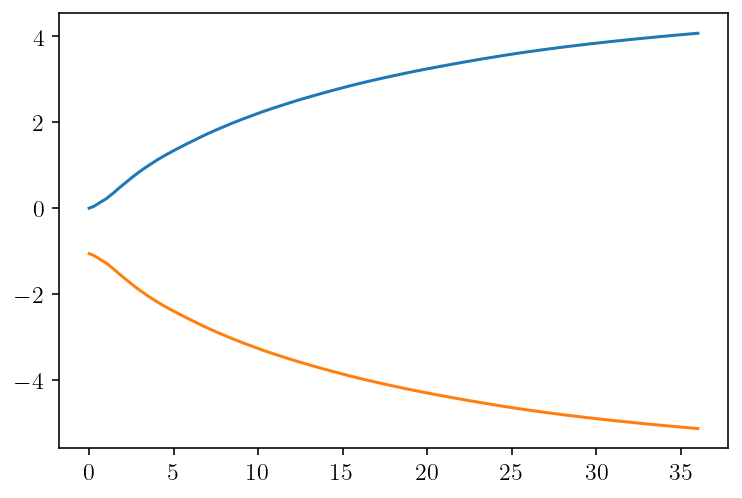

In [155]:
traces = np.trace(hess[:, sig_idx,:,:], axis1=1, axis2=2)
plt.plot(ts, third_tensor.sum(axis=(1,2,3)))
plt.plot(ts, traces)
plt.show()

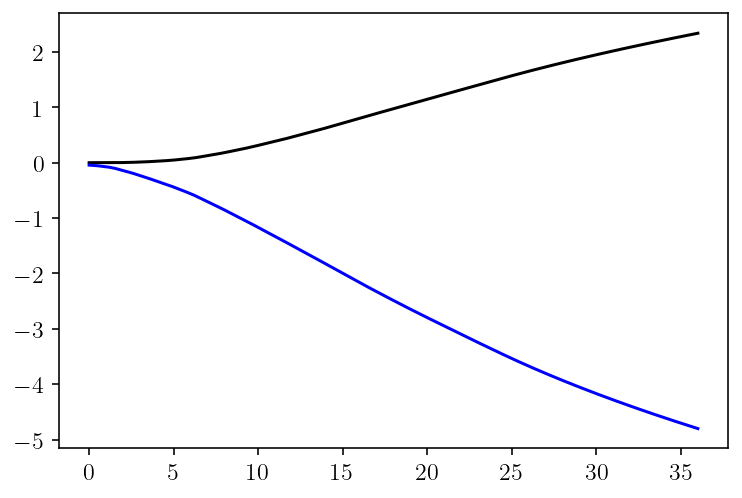

In [157]:
plt.plot(ts, prod3, 'k-')
plt.plot(ts, dethess[:,sig_idx], 'b-')
plt.show()

## Less informative prior is able to break things

In [165]:
mu_mean = 0.0
mu_sig2 = 100.0
sig2_alpha = 0.0005
sig2_beta = 0.000005

def sample(suff_stats):
    mu = numpyro.sample("mu", dist.Normal(mu_mean, jnp.sqrt(mu_sig2)))
    sigma2 = numpyro.sample("sigma2", dist.InverseGamma(sig2_alpha, sig2_beta))
    for j in range(narms):
        rhoj = numpyro.sample(f"rho{j}", dist.Normal(mu, jnp.sqrt(sigma2)))
        numpyro.sample(
            f"x{j}",
            CensoredExponential(1.0 / (jnp.exp(rhoj) * lambdaj[j])),
            obs=suff_stats[j],
        )

In [166]:
n_samples = 100000
kernel = numpyro.infer.NUTS(sample)
mcmc = numpyro.infer.MCMC(
    kernel,
    progress_bar=False,
    num_warmup=100,
    num_samples=n_samples,
    jit_model_args=True,
)
rng_key = jax.random.PRNGKey(10)

In [168]:
@jax.jit
def log_joint(data, rho, neg_precQ, logprecQdet, log_prior):
    """
    theta is expected to have shape (N, n_sigma2, n_arms)
    """
    n_events = data[..., 0]
    total_obs_time = data[..., 1]
    rho_m0 = rho - mu_mean
    hazard = 1.0 / (jnp.exp(rho) * lambdaj[None])
    return (
        0.5 * jnp.einsum("...i,...ij,...j", rho_m0, neg_precQ, rho_m0)
        + logprecQdet
        + jnp.sum(
            jnp.log(hazard) * n_events[:, None] - hazard * total_obs_time[:, None],
            axis=-1,
        )
        + log_prior
    )


def scalar_log_joint_opt(rho, neg_precQ, n_events, total_obs_time):
    """
    theta is expected to have shape (N, n_sigma2, n_arms)
    """
    rho_m0 = rho - mu_mean
    hazard = 1.0 / (jnp.exp(rho) * lambdaj)
    return 0.5 * neg_precQ.dot(rho_m0).T.dot(rho_m0) + jnp.sum(
        jnp.log(hazard) * n_events - hazard * total_obs_time
    )


grad_opt = jax.jit(
    jax.vmap(
        jax.vmap(jax.grad(scalar_log_joint_opt), in_axes=(0, 0, None, None)),
        in_axes=(0, None, 0, 0),
    )
)
hessian_opt = jax.jit(
    jax.vmap(
        jax.vmap(jax.hessian(scalar_log_joint_opt), in_axes=(0, 0, None, None)),
        in_axes=(0, None, 0, 0),
    )
)

def grad_hess(fi, data, rho, arms_opt):
    grad = grad_opt(rho, fi.neg_precQ, data[..., 0], data[..., 1])
    hess = hessian_opt(rho, fi.neg_precQ, data[..., 0], data[..., 1])
    return grad, hess


import berrylib.fast_inla as fast_inla

def log_joint_wrapper(fi, data, rho):
    return log_joint(data, rho, fi.neg_precQ, fi.logprecQdet, fi.log_prior)

model = fast_inla.FastINLAModel(log_joint_wrapper, grad_hess)
fi = fast_inla.FastINLA(
    model=model,
    n_arms=3,
    mu_0=mu_mean,
    mu_sig2=mu_sig2,
    sigma2_n=20,
    sigma2_bounds=[1e-6, 100.0],
    sigma2_alpha=sig2_alpha,
    sigma2_beta=sig2_beta,
)

In [170]:
np_inference = fi.numpy_inference(suff_stats)

In [175]:
suff_stats[1]

array([[0.      , 0.      , 0.      ],
       [0.      , 0.018009, 1.      ],
       [0.      , 0.      , 0.      ]])

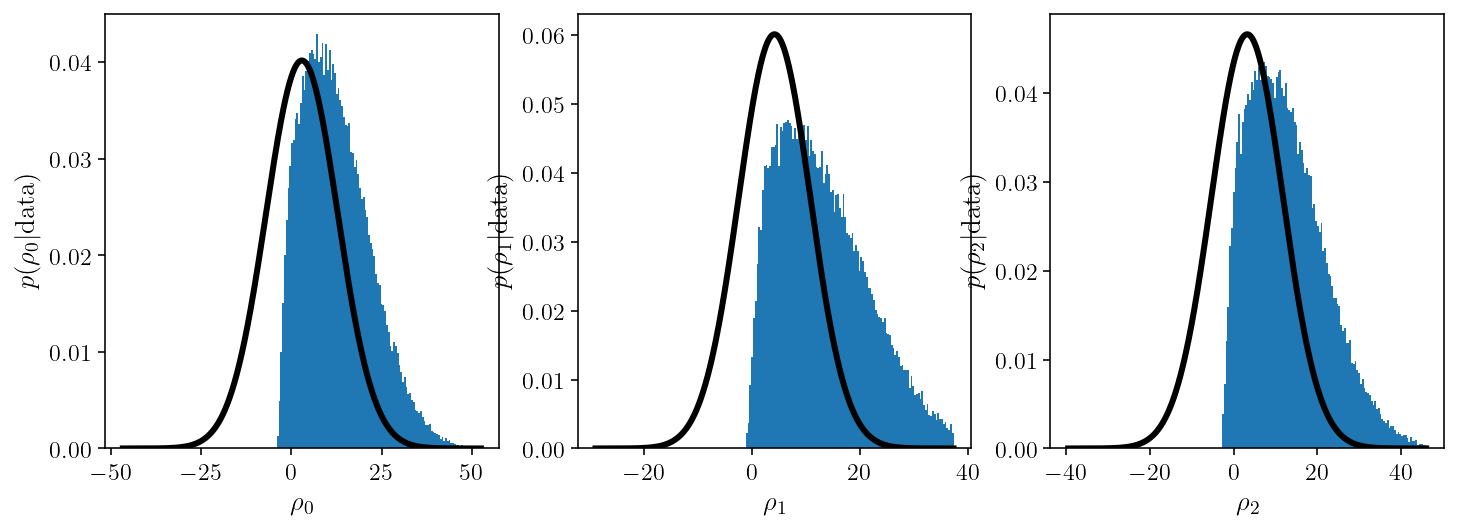

In [176]:
i = 100
for sig_idx in [19]:#range(0, 20, 3):
    sample_fixed_sigma2 = numpyro.handlers.condition(sample, dict(sigma2=fi.sigma2_rule.pts[sig_idx]))
    n_samples = 100000
    kernel = numpyro.infer.NUTS(sample_fixed_sigma2)
    mcmc_fixed_sigma2 = numpyro.infer.MCMC(
        kernel,
        progress_bar=False,
        num_warmup=100,
        num_samples=n_samples,
        jit_model_args=True,
    )
    samples_fixed, rho_samples_fixed = mcmc_run(mcmc_fixed_sigma2, suff_stats[i])
    theta_max = np_inference[2][i]
    theta_sigma = np_inference[3][i]
    plt.figure(figsize=(12, 4))
    for j in range(3):
        plt.subplot(1, 3, 1 + j)
        vmin = theta_max[sig_idx, j] - 5 * theta_sigma[sig_idx, j]
        vmax = theta_max[sig_idx, j] + 5 * theta_sigma[sig_idx, j]
        plt_vs = np.linspace(vmin, vmax, 1000)
        plt.hist(rho_samples_fixed[:, j], density=True, bins=np.linspace(vmin, vmax, 201))
        # plt.vlines([theta_max[sig_idx, j]], [0], [1], colors='k', linestyles='solid')
        plt.plot(plt_vs, scipy.stats.norm.pdf(plt_vs, theta_max[sig_idx, j], theta_sigma[sig_idx, j]), 'k-', linewidth=3)
        plt.ylabel(f'$p(\\rho_{j}' + ' | \mathrm{data})$')
        plt.xlabel(f'$\\rho_{j}$')
    plt.show()